Plot NWP, PV, GSP PV, and ESO PV forecasts

Based on: https://github.com/openclimatefix/predict_pv_yield_OLD/blob/main/notebooks/data_analysis/001-animate_sat_images_and_pv.ipynb

In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
from matplotlib import cm
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import dask
from IPython import display
import pandas as pd
import numpy as np
import geopandas as gpd
from typing import Optional, Union, Iterable

In [2]:
START_TIME = "2021-06-10 04:00"
END_TIME = "2021-06-10 21:00"

In [3]:
BASE_PATH = Path("/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/")
SATELLITE_PATH = BASE_PATH / "satellite/EUMETSAT/SEVIRI_RSS/zarr/v3/eumetsat_seviri_hrv_uk.zarr"
NWP_PATH = BASE_PATH / "NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_3.zarr"

WGS84 = "EPSG:4326"

assert SATELLITE_PATH.exists()
assert NWP_PATH.exists()

## Open and prepare satellite data

In [4]:
satellite_dataset = xr.open_dataset(SATELLITE_PATH, engine="zarr", chunks="auto")

In [5]:
satellite_dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>

In [6]:
selected_sat_dataset = satellite_dataset.sel(time=slice(START_TIME, END_TIME))["data"]
sat_datetime_index = pd.DatetimeIndex(selected_sat_dataset.time)

In [7]:
# Compute min and max values (these will be used during plotting to make sure the "exposure" doesn't change from frame-to-frame).
min_satellite_value = selected_sat_dataset.min()
max_satellite_value = selected_sat_dataset.max()
min_satellite_value, max_satellite_value = dask.compute(min_satellite_value, max_satellite_value)

## Open and prepare NWP data

In [8]:
nwp_dataset = xr.open_dataset(NWP_PATH, engine="zarr", chunks="auto")

In [21]:
def _get_nwp_data(dt: pd.Timestamp, variable: Union[str, Iterable[str]]) -> xr.DataArray:
    dt = pd.Timestamp(dt)
    dt_hourly = dt.floor("H")
    init_time_i = np.searchsorted(nwp_dataset.init_time, dt_hourly.to_numpy(), side="right")
    init_time_i -= 1  # Because searchsorted() gives the index to the entry _after_.
    init_time = nwp_dataset.init_time.values[init_time_i]
    step = dt_hourly - init_time
    return nwp_dataset["UKV"].sel(init_time=init_time, step=step, variable=variable)

def get_nwp_data(dt: pd.Timestamp, variable: str) -> xr.DataArray:
    if variable == "total_cloud":
        return _get_nwp_data(dt=dt, variable=["lcc", "mcc", "hcc"]).mean(dim="variable")
    else:
        return _get_nwp_data(dt=dt, variable=variable)

In [22]:
get_nwp_data(START_TIME, variable="total_cloud")

<xarray.DataArray 'UKV' (y: 704, x: 548)>
dask.array<mean_agg-aggregate, shape=(704, 548), dtype=float32, chunksize=(704, 548), chunktype=numpy.ndarray>
Coordinates:
    init_time  datetime64[ns] 2021-06-10T03:00:00
    step       timedelta64[ns] 01:00:00
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000

## Animate!

In [57]:
def get_nwp_time_string(selected_nwp_data) -> str:
    init_time = pd.Timestamp(selected_nwp_data.init_time.values).strftime('%Y-%m-%dT%H')
    step = int(selected_nwp_data.step.values / np.timedelta64(1, "h"))
    nwp_title_str = "NWP total_cloud"
    nwp_title_str += f"\n init_time={init_time}"
    nwp_title_str += f" step={step} H"
    return nwp_title_str

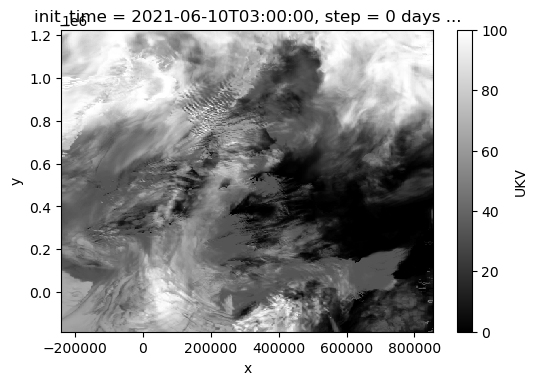

In [24]:
selected_nwp_data = get_nwp_data(START_TIME, variable="total_cloud")
selected_nwp_data.plot.pcolormesh(
    cmap="gray",
    vmin=0,
    vmax=100,
);

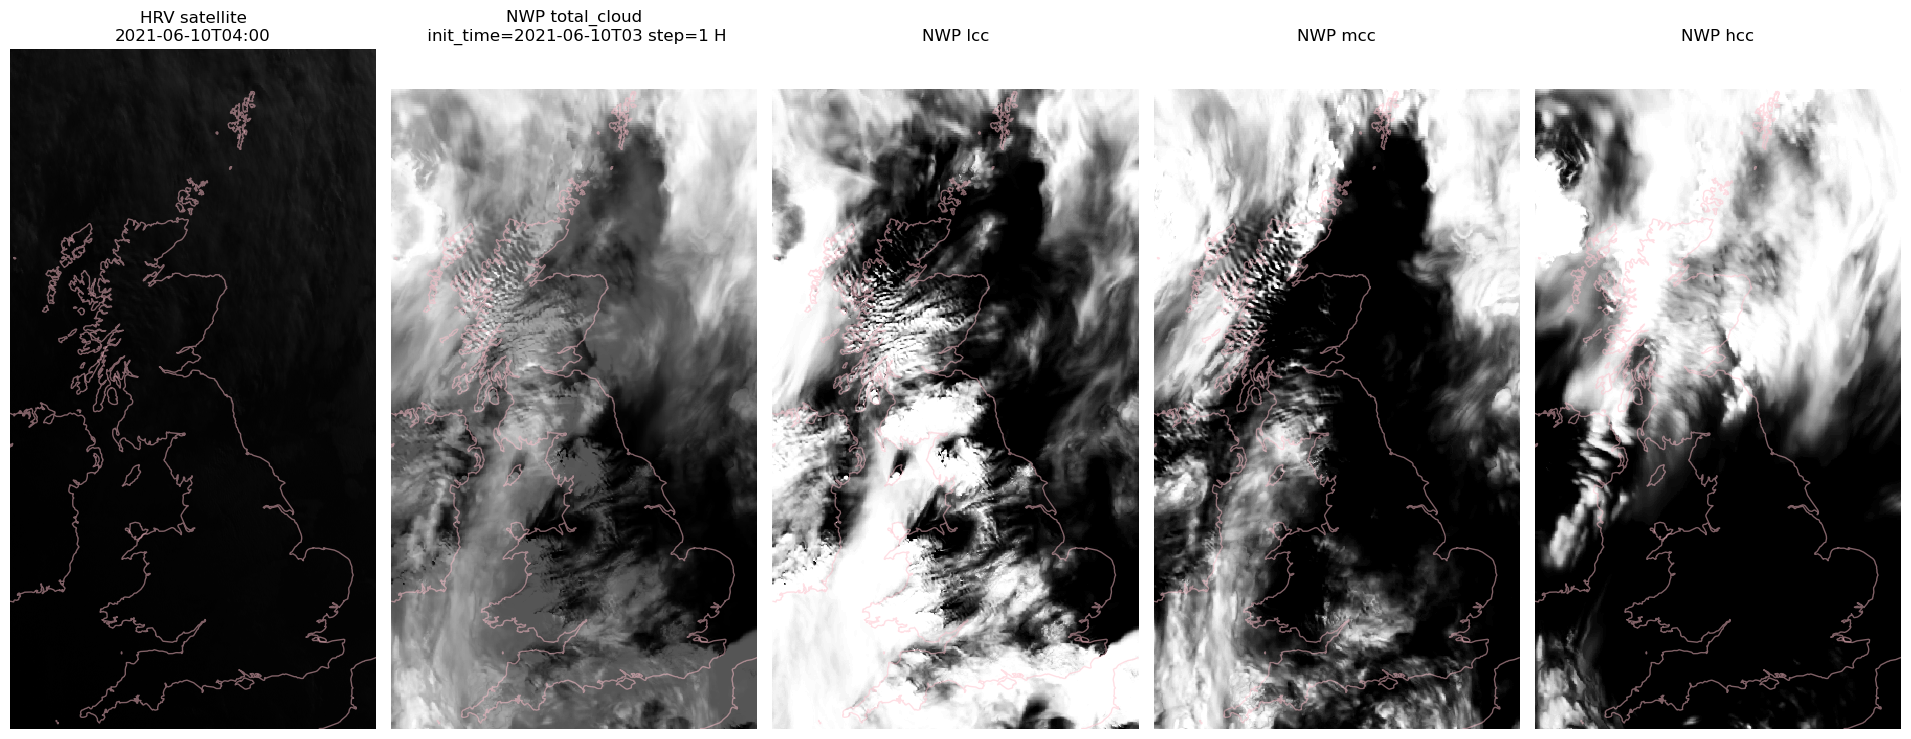

In [67]:
# SET UP THE FIGURE
# Spatial layout
NROWS = 1
NCOLS = 5
SHAPE = (NROWS, NCOLS)
dpi = 100
plt.rcParams['figure.dpi'] = dpi

fig = plt.figure(
    figsize=(
        19.21,
        10.80
    ))
projection = ccrs.OSGB(approx=False)
geospatial_plot_kwargs = dict(projection=projection, rowspan=NROWS)
sat_ax     = plt.subplot2grid(SHAPE, loc=(0, 0), **geospatial_plot_kwargs)
nwp_axes = {
    "total_cloud": plt.subplot2grid(SHAPE, loc=(0, 1), **geospatial_plot_kwargs),
    "lcc": plt.subplot2grid(SHAPE, loc=(0, 2), **geospatial_plot_kwargs),
    "mcc": plt.subplot2grid(SHAPE, loc=(0, 3), **geospatial_plot_kwargs),
    "hcc": plt.subplot2grid(SHAPE, loc=(0, 4), **geospatial_plot_kwargs),
}
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.99, top=0.99, wspace=None, hspace=None)

# Colours
#fig.patch.set_facecolor('black')
#sat_ax.set_facecolor('black')

CMAP = "gray"

## SATELLITE ####################################################
# Plot first frame of satellite data
sat_img = selected_sat_dataset.isel(time=0).plot.pcolormesh(
    ax=sat_ax,
    transform=ccrs.Geostationary(central_longitude=9.5),
    x="x",
    y="y",
    add_colorbar=False,
    cmap=CMAP,
    vmin=min_satellite_value.data,
    vmax=max_satellite_value.data,
)
sat_time = pd.Timestamp(selected_sat_dataset.isel(time=0).time.values).strftime("%Y-%m-%dT%H:%M")
sat_title_obj = sat_ax.set_title(f"HRV satellite\n{sat_time}")

## NWP #########################################################
nwp_imgs = {}
for nwp_var_name, nwp_ax in nwp_axes.items():
    selected_nwp_data = get_nwp_data(START_TIME, variable=nwp_var_name)
    nwp_imgs[nwp_var_name] = selected_nwp_data.plot.pcolormesh(
        ax=nwp_ax,
        transform=ccrs.OSGB(approx=False),
        add_colorbar=False,
        cmap=CMAP,
        vmin=0,
        vmax=100,
    )
    nwp_title_str = f"NWP {nwp_var_name}"
    if nwp_var_name == "total_cloud":
        nwp_title_str = get_nwp_time_string(selected_nwp_data)
        nwp_title_obj = nwp_ax.set_title(nwp_title_str)
    else:
        nwp_ax.set_title(nwp_title_str)
    nwp_ax.set_ylim(sat_ax.get_ylim())
    nwp_ax.set_xlim(sat_ax.get_xlim())


## FORMAT GEO PLOTS #########################################
for ax in list(nwp_axes.values()) + [sat_ax]:
    ax.coastlines(resolution='10m', alpha=0.5, color='pink')
    ax.set_frame_on(False)

plt.tight_layout(
    h_pad=3, 
    rect=(0, 0, 1, 0.95),  # left, bottom, right, top
)

In [74]:
# Animation function
def update(i: int = 0):
    # Satellite
    new_sat_data = selected_sat_dataset.isel(time=i)
    sat_img.set_array(new_sat_data.values.ravel())
    dt = pd.Timestamp(new_sat_data.time.values)
    sat_title_obj.set_text("HRV satellite\n" + dt.strftime("%Y-%m-%dT%H:%M"))
    
    # NWP
    for nwp_var_name, nwp_img in nwp_imgs.items():
        new_nwp_data = get_nwp_data(dt, variable=nwp_var_name)
        nwp_img.set_array(new_nwp_data.values.ravel())
        if nwp_var_name == "total_cloud":
            nwp_title_obj.set_text(get_nwp_time_string(new_nwp_data))

In [75]:
#anim = FuncAnimation(fig, update, frames=range(80, 100, 5), interval=80, blit=True)
#video = anim.to_html5_video()
#display.HTML(video)

In [91]:
# Docs: https://matplotlib.org/stable/api/animation_api.html#writer-classes
metadata = dict(title='UK solar PV, NWP and clouds in June 2021', artist='Open Climate Fix')
moviewriter = FFMpegFileWriter(fps=2, bitrate=100000, metadata=metadata)
moviewriter._tmpdir = None
with moviewriter.saving(fig, 'pv_animation_nwp_cloud_cover.mp4', dpi=dpi):
    for i in np.arange(len(sat_datetime_index)): # range(60, 96, 6):
        print(f"{sat_datetime_index[i]}\r", end="", flush=True)
        update(i)
        moviewriter.grab_frame(bbox_inches='tight', facecolor='white')